<a href="https://colab.research.google.com/github/atheendre130505/gans_monet/blob/main/monet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()  # upload photo.zip and monet.zip


Saving monet.zip to monet (1).zip
Saving photo.zip to photo (1).zip
Buffered data was truncated after reaching the output size limit.

In [ ]:
import zipfile, os

for fname in ['photo.zip', 'monet.zip']:
    with zipfile.ZipFile(fname, 'r') as zip_ref:
        zip_ref.extractall('/content/dataset')
print(os.listdir('/content/dataset'))


['photo_jpg', 'monet_jpg']


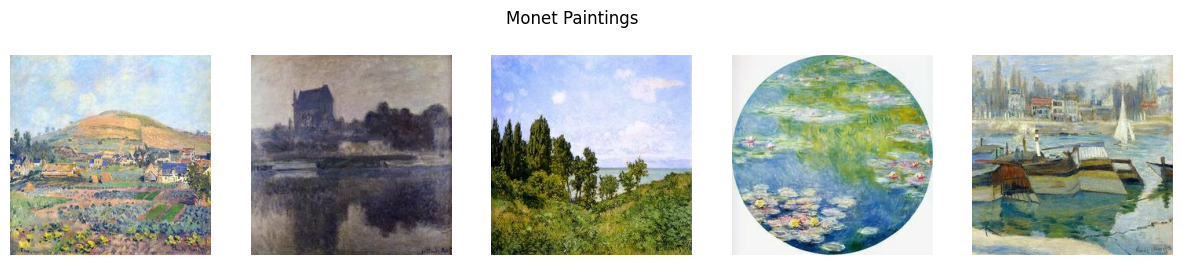

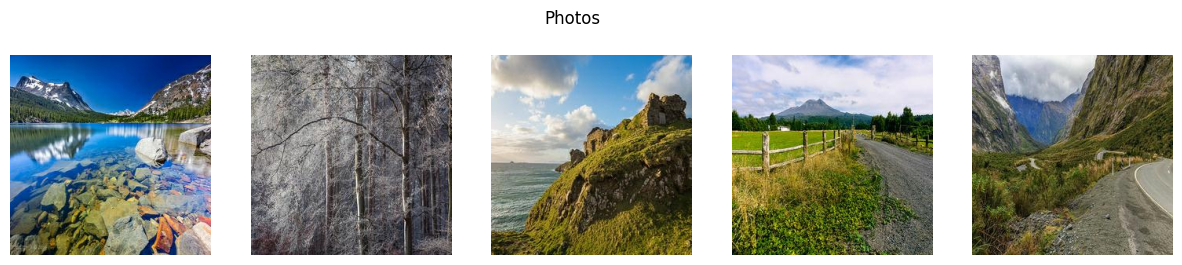

In [ ]:
import matplotlib.pyplot as plt
import cv2
import random
from glob import glob

monet_paths = glob('/content/dataset/monet_jpg/*')
photo_paths = glob('/content/dataset/photo_jpg/*')

def show_samples(img_paths, title, n=5):
    plt.figure(figsize=(15,3))
    for i, path in enumerate(random.sample(img_paths, n)):
        img = cv2.imread(path)[:,:,::-1]
        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_samples(monet_paths, "Monet Paintings")
show_samples(photo_paths, "Photos")


In [ ]:
import os, random
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

DATA_DIR = '/content/dataset'  # adjust if different
monet_paths = sorted(glob(os.path.join(DATA_DIR, 'monet_jpg', '*')))
photo_paths = sorted(glob(os.path.join(DATA_DIR, 'photo_jpg', '*')))

print(f'Monet images: {len(monet_paths)}')
print(f'Photo images: {len(photo_paths)}')
assert len(monet_paths) > 0 and len(photo_paths) > 0, "No images found—check extracted paths."


Monet images: 300
Photo images: 7038


In [ ]:
def read_img_cv2(p):
    img = cv2.imread(p)
    if img is None:
        return None
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def stats_on_sample(paths, k=50):
    sample = random.sample(paths, min(k, len(paths)))
    shapes, corrupt = [], 0
    for p in sample:
        img = read_img_cv2(p)
        if img is None:
            corrupt += 1
            continue
        shapes.append(img.shape)
    return shapes, corrupt

monet_shapes, monet_corrupt = stats_on_sample(monet_paths, k=100)
photo_shapes, photo_corrupt = stats_on_sample(photo_paths, k=100)

print(f"Monet sample corrupt: {monet_corrupt}, example shapes: {set(monet_shapes)}")
print(f"Photo sample corrupt: {photo_corrupt}, example shapes: {set(photo_shapes)}")


Monet sample corrupt: 0, example shapes: {(256, 256, 3)}
Photo sample corrupt: 0, example shapes: {(256, 256, 3)}


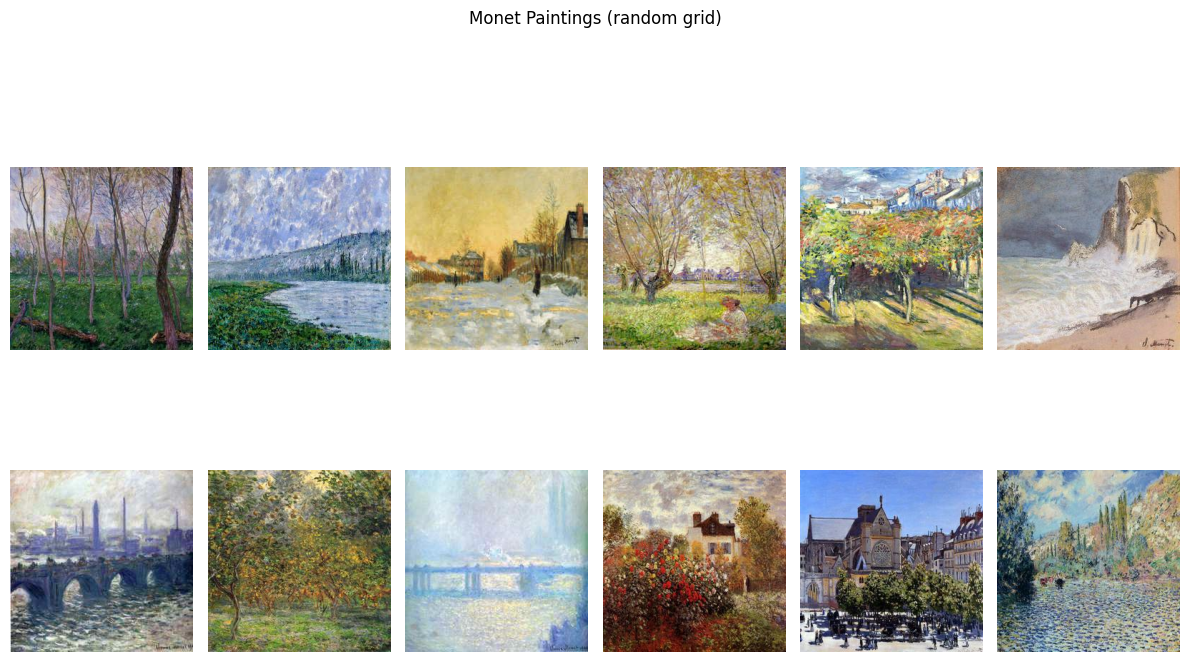

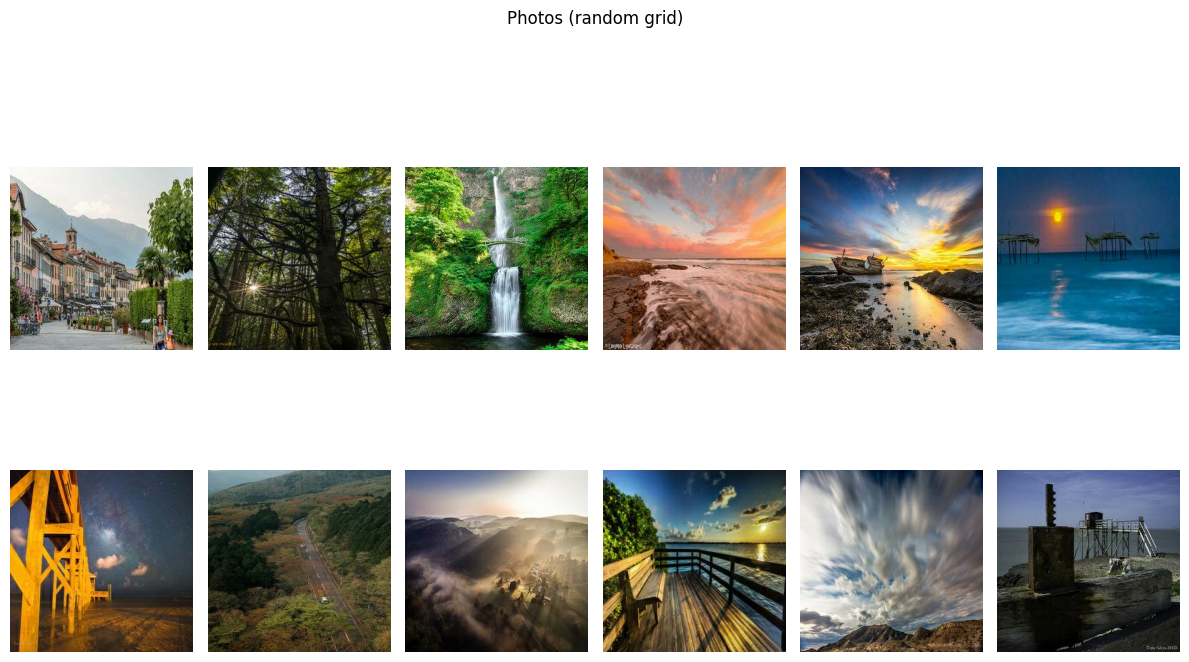

In [ ]:
def show_grid(paths, title, n=12, cols=6, figsize=(12,8)):
    n = min(n, len(paths))
    sel = random.sample(paths, n)
    rows = int(np.ceil(n/cols))
    plt.figure(figsize=figsize)
    for i, p in enumerate(sel, 1):
        img = read_img_cv2(p)
        if img is None:
            continue
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_grid(monet_paths, "Monet Paintings (random grid)")
show_grid(photo_paths, "Photos (random grid)")


In [ ]:
def load_tf(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    img = tf.image.resize(img, [256, 256])               # enforce size
    return img

def sample_tensor_stats(paths, k=200):
    sel = random.sample(paths, min(k, len(paths)))
    arrs = []
    for p in sel:
        img = load_tf(p).numpy()  # H,W,3 in [0,1]
        arrs.append(img.reshape(-1,3))
    allpix = np.concatenate(arrs, axis=0)
    mean = allpix.mean(axis=0)
    std = allpix.std(axis=0)
    mn, mx = allpix.min(), allpix.max()
    return mean, std, mn, mx

monet_mean, monet_std, monet_min, monet_max = sample_tensor_stats(monet_paths, k=200)
photo_mean, photo_std, photo_min, photo_max = sample_tensor_stats(photo_paths, k=200)

print("Monet mean/std per channel (RGB):", monet_mean, monet_std, "min/max:", monet_min, monet_max)
print("Photo mean/std per channel (RGB):", photo_mean, photo_std, "min/max:", photo_min, photo_max)


Monet mean/std per channel (RGB): [0.5125465  0.51820666 0.46381024] [0.22338842 0.21690114 0.24254978] min/max: 0.0 1.0
Photo mean/std per channel (RGB): [0.39650163 0.40823856 0.36920342] [0.2606793  0.24382186 0.26638436] min/max: 0.0 1.0


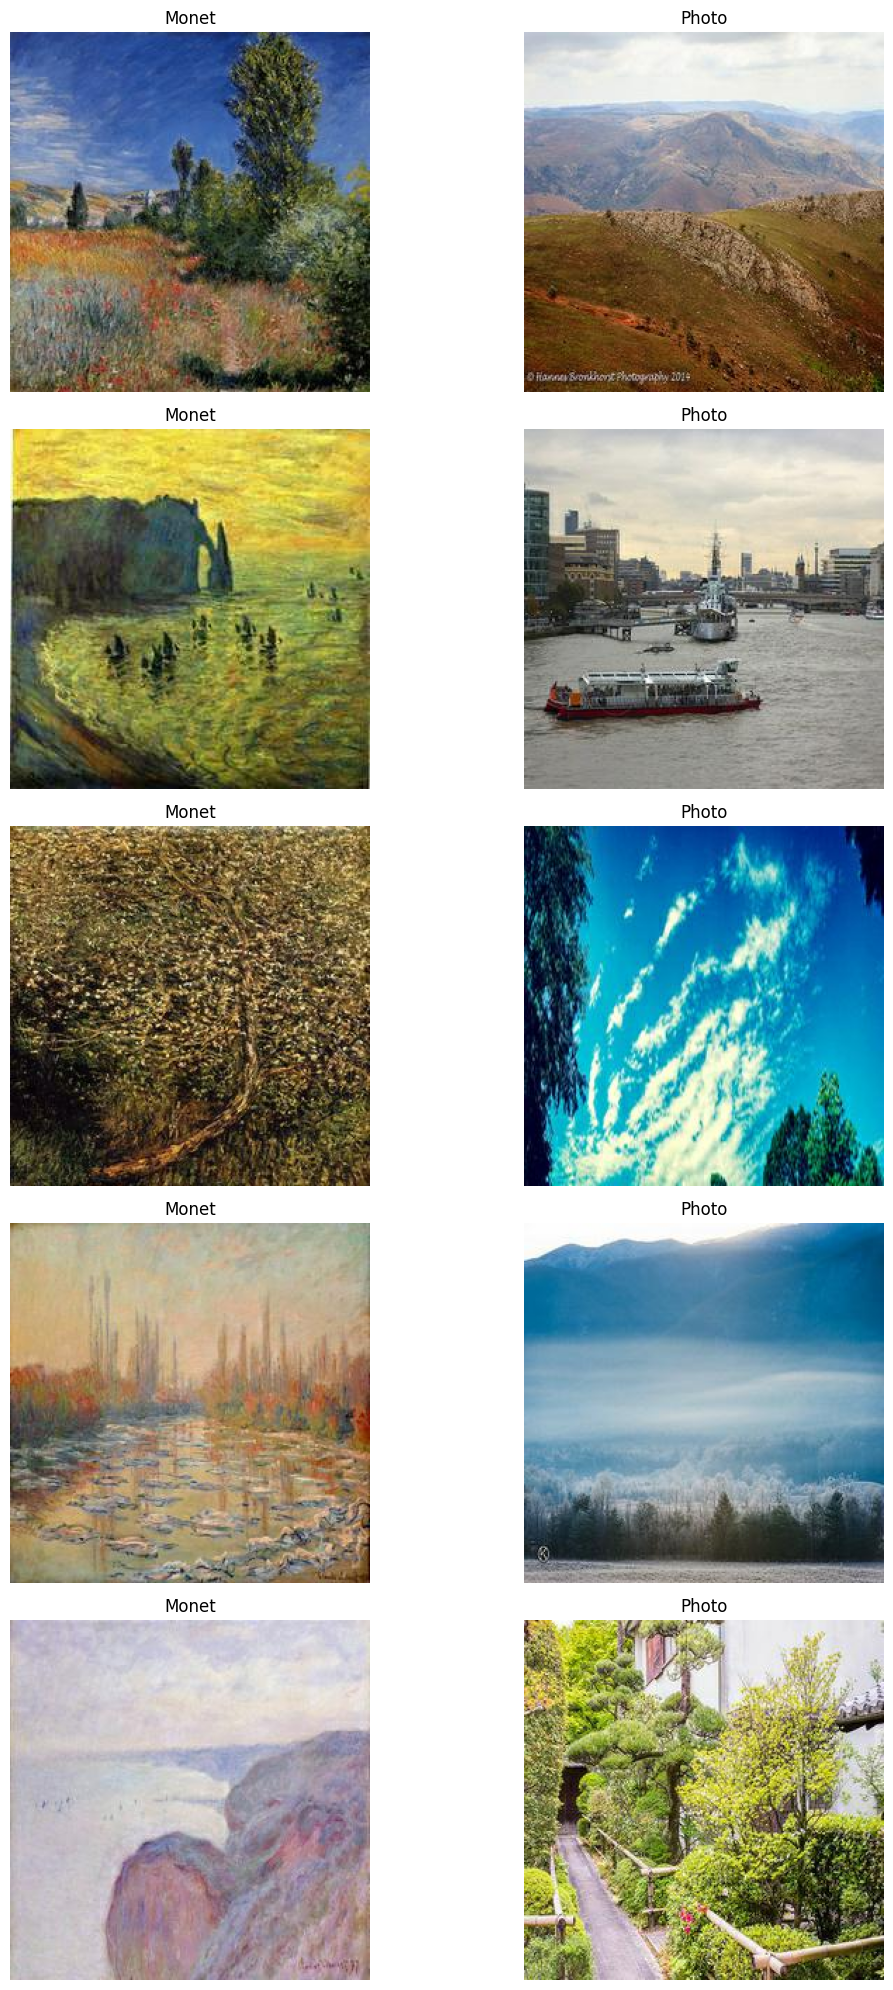

In [ ]:
def show_pairs(monet_paths, photo_paths, n=5):
    msel = random.sample(monet_paths, n)
    psel = random.sample(photo_paths, n)
    plt.figure(figsize=(12, 4*n))
    for i, (mp, pp) in enumerate(zip(msel, psel), 1):
        mimg = read_img_cv2(mp)
        pimg = read_img_cv2(pp)
        plt.subplot(n, 2, 2*i-1); plt.imshow(mimg); plt.axis('off'); plt.title('Monet')
        plt.subplot(n, 2, 2*i);   plt.imshow(pimg); plt.axis('off'); plt.title('Photo')
    plt.tight_layout()
    plt.show()

show_pairs(monet_paths, photo_paths, n=5)



In [ ]:
IMG_SIZE = 256
BATCH = 8
AUTO = tf.data.AUTOTUNE

def decode_resize_norm(path):
    img = load_tf(path)                 # [0,1]
    img = (img * 2.0) - 1.0            # [-1,1]
    return img

def augment(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_jpeg_quality(img, 70, 100)  # slight compression variation
    # small color jitter
    img = tf.image.random_brightness(img, max_delta=0.05)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
    return img

def make_ds(paths, training=True):
    ds = tf.data.Dataset.from_tensor_slices(paths)
    ds = ds.shuffle(len(paths), reshuffle_each_iteration=True) if training else ds
    ds = ds.map(decode_resize_norm, num_parallel_calls=AUTO)
    if training:
        ds = ds.map(augment, num_parallel_calls=AUTO)
    ds = ds.batch(BATCH).prefetch(AUTO)
    return ds

monet_ds = make_ds(monet_paths, training=True)
photo_ds = make_ds(photo_paths, training=True)

monet_iter = iter(monet_ds)
photo_iter = iter(photo_ds)

sample_batch_monet = next(monet_iter)
sample_batch_photo = next(photo_iter)
sample_batch_monet.shape, sample_batch_photo.shape


(TensorShape([8, 256, 256, 3]), TensorShape([8, 256, 256, 3]))

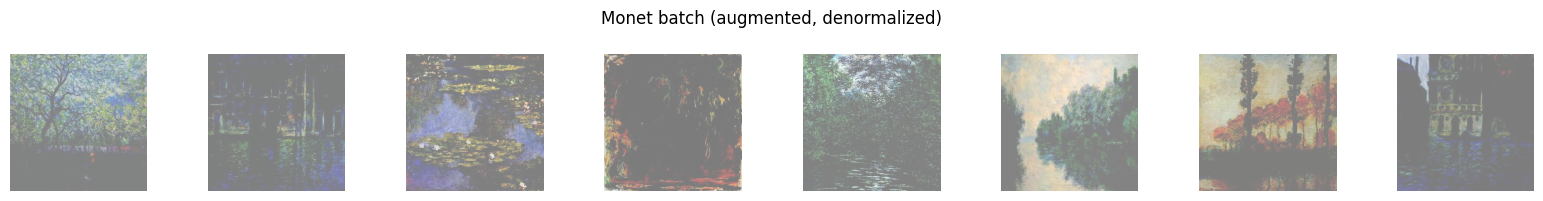

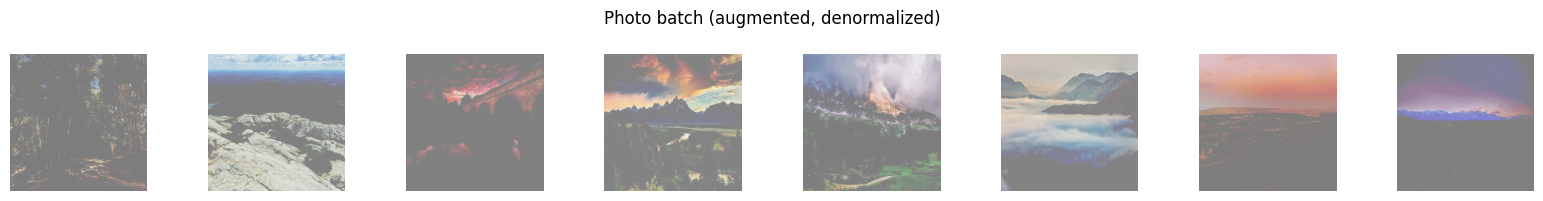

In [ ]:
def denorm(x):
    return tf.clip_by_value((x + 1.0)/2.0, 0.0, 1.0)

def show_batch(batch, title="Batch"):
    imgs = denorm(batch).numpy()
    n = min(8, imgs.shape[0])
    cols = 8
    rows = int(np.ceil(n/cols))
    plt.figure(figsize=(16, 2*rows))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(imgs[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_batch(sample_batch_monet, "Monet batch (augmented, denormalized)")
show_batch(sample_batch_photo, "Photo batch (augmented, denormalized)")


In [ ]:
!pip install tensorflow.keras

In [ ]:
import os, time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Reuse monet_ds, photo_ds, denorm from Step 2
IMG_SIZE = 256
LATENT_DIM = 128
BATCH_SIZE = 8        # keep small for Colab memory
LR = 2e-4
BETA_1 = 0.5
EPOCHS = 10           # start small; increase after verifying training
SAMPLE_DIR = '/content/vanilla_gan_samples'
CKPT_DIR = '/content/vanilla_gan_ckpts'
os.makedirs(SAMPLE_DIR, exist_ok=True)
os.makedirs(CKPT_DIR, exist_ok=True)

def plot_samples(imgs, step, n=8, fname=None):
    imgs = denorm(imgs)  # back to [0,1]
    n = min(n, imgs.shape[0])
    cols = 4
    rows = int(np.ceil(n/cols))
    plt.figure(figsize=(cols*3, rows*3))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(imgs[i])
        plt.axis('off')
    plt.suptitle(f'Step {step}')
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=120)
        plt.close()
    else:
        plt.show()
